In [ ]:
import numpy as np
import pandas as pd

# machine learning
import keras
# data visualization
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns

Load Data

In [5]:
data = pd.read_csv("sig_samples/sig_samples/rinv0_pTmin200GeV.txt", sep = " ")
data.head(0)

,pT_j1,eta_j1,phi_j1,pT_j2,eta_j2,phi_j2,m_jj,tau21_j1,tau21_j2,tau32_j1,tau32_j2,met,phi_met,min_dPhi,ht,Unnamed: 15


In [11]:
training_df = data[["ht", "met", "m_jj", "tau21_j1", "tau21_j2", "tau32_j1", "tau32_j2"]]

print('Read dataset completed successfully.')
print('Total number of rows: {0}\n\n'.format(len(training_df.index)))
training_df.head(200)

Read dataset completed successfully.
Total number of rows: 7895




,ht,met,m_jj,tau21_j1,tau21_j2,tau32_j1,tau32_j2
0,2521.080,65.9754,2646.400,0.168509,0.455646,0.772128,0.596539
1,2646.920,73.7713,3537.040,0.390341,0.299602,0.316059,0.558199
2,1109.810,15.3179,1219.950,0.559273,0.541733,0.665168,0.793866
3,2439.700,87.1133,2425.430,0.517106,0.474470,0.610648,0.586094
4,3510.170,128.0180,3298.180,0.166202,0.621271,0.765165,0.334743
...,...,...,...,...,...,...,...
195,745.409,175.5570,928.230,0.682423,0.427676,0.544343,0.626117
196,3171.540,118.0100,3402.400,0.465119,0.170626,0.585994,0.741585
197,465.817,62.9264,479.631,0.607403,0.665929,0.724355,0.771348
198,2431.230,307.1510,3251.840,0.201895,0.285142,0.717277,0.511856


In [14]:
#@title Code - View dataset statistics
print('The headers are', training_df.head(0))
print('Total number of rows: {0}\n\n'.format(len(training_df.index)))
training_df.describe(include='all')

columns = ["ht", "met", "m_jj", "tau21_j1", "tau21_j2", "tau32_j1", "tau32_j2"]
for col in columns:
    print(f"There are {training_df[col].isnull().sum()} null values in the Feature {col}")

The headers are Empty DataFrame
Columns: [ht, met, m_jj, tau21_j1, tau21_j2, tau32_j1, tau32_j2]
Index: []
Total number of rows: 7895


There are 0 null values in the Feature ht
There are 0 null values in the Feature met
There are 0 null values in the Feature m_jj
There are 0 null values in the Feature tau21_j1
There are 0 null values in the Feature tau21_j2
There are 0 null values in the Feature tau32_j1
There are 0 null values in the Feature tau32_j2


In [20]:
correlation_matrix = training_df.corr(numeric_only=True)

# Assuming training_df is your DataFrame
correlation_matrix = training_df.corr(numeric_only=True)

# Create a heatmap using Plotly
fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,
    x=correlation_matrix.columns,
    y=correlation_matrix.columns,
    colorscale='Plasma',  # Choose a different colorscale for better contrast
    colorbar=dict(title='Correlation', tickformat=".2f"),  # Customize the colorbar
    zmin=-1, zmax=1  # Set the range of the color scale
))

# Customize the layout
fig.update_layout(
    title='Correlation Matrix',
    xaxis=dict(ticks='', dtick=1, tickangle=45, tickfont=dict(size=10)),  # Customize x-axis ticks
    yaxis=dict(ticks='', dtick=1, tickfont=dict(size=10)),  # Customize y-axis ticks
    margin=dict(l=50, r=50, t=70, b=50),  # Adjust margins for better spacing
    width=800, height=800  # Set the size of the plot
)

# Display the plot
fig.show()

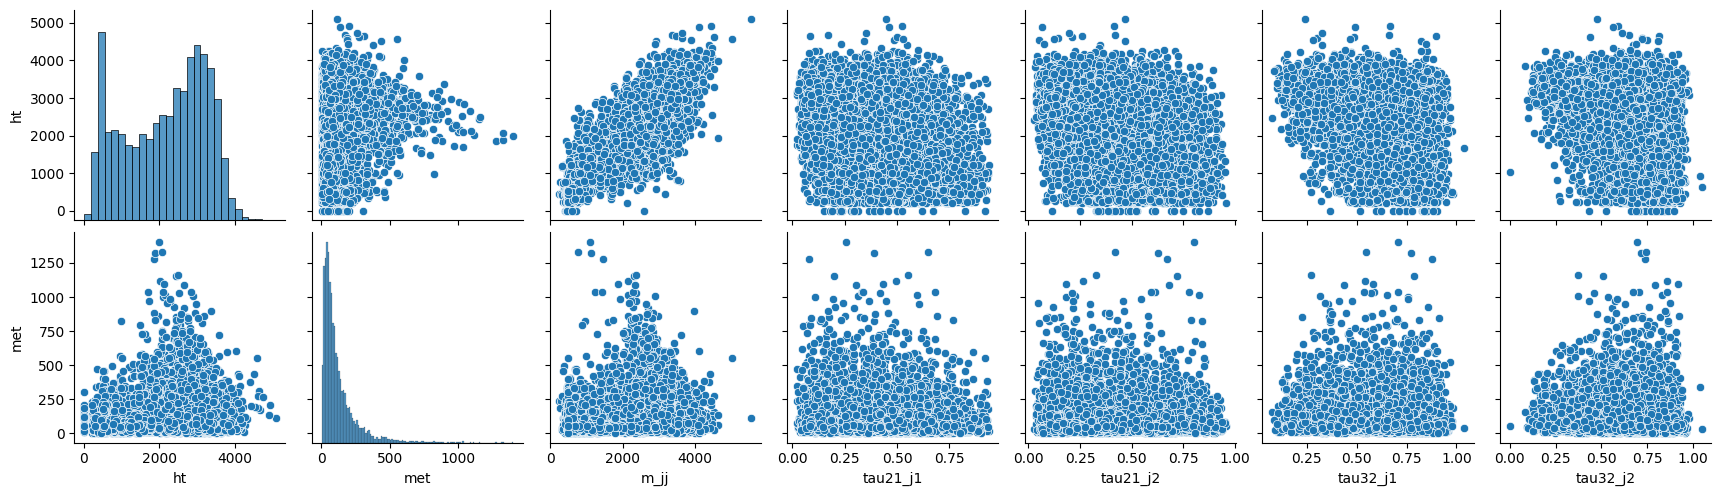

In [21]:
sns.pairplot(training_df, x_vars=columns, y_vars=["ht", "met"])

In [22]:
#@title Define plotting functions

def make_plots(df, feature_names, label_name, model_output, sample_size=200):

  random_sample = df.sample(n=sample_size).copy()
  random_sample.reset_index()
  weights, bias, epochs, rmse = model_output

  is_2d_plot = len(feature_names) == 1
  model_plot_type = "scatter" if is_2d_plot else "surface"
  fig = make_subplots(rows=1, cols=2,
                      subplot_titles=("Loss Curve", "Model Plot"),
                      specs=[[{"type": "scatter"}, {"type": model_plot_type}]])

  plot_data(random_sample, feature_names, label_name, fig)
  plot_model(random_sample, feature_names, weights, bias, fig)
  plot_loss_curve(epochs, rmse, fig)

  fig.show()
  return

def plot_loss_curve(epochs, rmse, fig):
  curve = px.line(x=epochs, y=rmse)
  curve.update_traces(line_color='#ff0000', line_width=3)

  fig.append_trace(curve.data[0], row=1, col=1)
  fig.update_xaxes(title_text="Epoch", row=1, col=1)
  fig.update_yaxes(title_text="Root Mean Squared Error", row=1, col=1, range=[rmse.min()*0.8, rmse.max()])

  return

def plot_data(df, features, label, fig):
  if len(features) == 1:
    scatter = px.scatter(df, x=features[0], y=label)
  else:
    scatter = px.scatter_3d(df, x=features[0], y=features[1], z=label)

  fig.append_trace(scatter.data[0], row=1, col=2)
  if len(features) == 1:
    fig.update_xaxes(title_text=features[0], row=1, col=2)
    fig.update_yaxes(title_text=label, row=1, col=2)
  else:
    fig.update_layout(scene1=dict(xaxis_title=features[0], yaxis_title=features[1], zaxis_title=label))

  return

def plot_model(df, features, weights, bias, fig):
  df['FARE_PREDICTED'] = bias[0]

  for index, feature in enumerate(features):
    df['FARE_PREDICTED'] = df['FARE_PREDICTED'] + weights[index][0] * df[feature]

  if len(features) == 1:
    model = px.line(df, x=features[0], y='FARE_PREDICTED')
    model.update_traces(line_color='#ff0000', line_width=3)
  else:
    z_name, y_name = "FARE_PREDICTED", features[1]
    z = [df[z_name].min(), (df[z_name].max() - df[z_name].min()) / 2, df[z_name].max()]
    y = [df[y_name].min(), (df[y_name].max() - df[y_name].min()) / 2, df[y_name].max()]
    x = []
    for i in range(len(y)):
      x.append((z[i] - weights[1][0] * y[i] - bias[0]) / weights[0][0])

    plane=pd.DataFrame({'x':x, 'y':y, 'z':[z] * 3})

    light_yellow = [[0, '#89CFF0'], [1, '#FFDB58']]
    model = go.Figure(data=go.Surface(x=plane['x'], y=plane['y'], z=plane['z'],
                                      colorscale=light_yellow))

  fig.add_trace(model.data[0], row=1, col=2)

  return

def model_info(feature_names, label_name, model_output):
  weights = model_output[0]
  bias = model_output[1]

  nl = "\n"
  header = "-" * 80
  banner = header + nl + "|" + "MODEL INFO".center(78) + "|" + nl + header

  info = ""
  equation = label_name + " = "

  for index, feature in enumerate(feature_names):
    info = info + "Weight for feature[{}]: {:.3f}\n".format(feature, weights[index][0])
    equation = equation + "{:.3f} * {} + ".format(weights[index][0], feature)

  info = info + "Bias: {:.3f}\n".format(bias[0])
  equation = equation + "{:.3f}\n".format(bias[0])

  return banner + nl + info + nl + equation

print("SUCCESS: defining plotting functions complete.")

SUCCESS: defining plotting functions complete.


In [23]:
#@title Code - Define ML functions

def build_model(my_learning_rate, num_features):
  """Create and compile a simple linear regression model."""
  # Most simple keras models are sequential.
  model = keras.models.Sequential()

  # Describe the topography of the model.
  # The topography of a simple linear regression model
  # is a single node in a single layer.
  model.add(keras.layers.Dense(units=1,
                                  input_shape=(num_features,)))

  # Compile the model topography into code that Keras can efficiently
  # execute. Configure training to minimize the model's mean squared error.
  model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=my_learning_rate),
                loss="mean_squared_error",
                metrics=[keras.metrics.RootMeanSquaredError()])

  return model


def train_model(model, df, features, label, epochs, batch_size):
  """Train the model by feeding it data."""

  # Feed the model the feature and the label.
  # The model will train for the specified number of epochs.
  # input_x = df.iloc[:,1:3].values
  # df[feature]
  history = model.fit(x=features,
                      y=label,
                      batch_size=batch_size,
                      epochs=epochs)

  # Gather the trained model's weight and bias.
  trained_weight = model.get_weights()[0]
  trained_bias = model.get_weights()[1]

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch

  # Isolate the error for each epoch.
  hist = pd.DataFrame(history.history)

  # To track the progression of training, we're going to take a snapshot
  # of the model's root mean squared error at each epoch.
  rmse = hist["root_mean_squared_error"]

  return trained_weight, trained_bias, epochs, rmse


def run_experiment(df, feature_names, label_name, learning_rate, epochs, batch_size):

  print('INFO: starting training experiment with features={} and label={}\n'.format(feature_names, label_name))

  num_features = len(feature_names)

  features = df.loc[:, feature_names].values
  label = df[label_name].values

  model = build_model(learning_rate, num_features)
  model_output = train_model(model, df, features, label, epochs, batch_size)

  print('\nSUCCESS: training experiment complete\n')
  print('{}'.format(model_info(feature_names, label_name, model_output)))
  make_plots(df, feature_names, label_name, model_output)

  return model

print("SUCCESS: defining linear regression functions complete.")

SUCCESS: defining linear regression functions complete.


In [24]:
#@title Code - Experiment 1

# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 50

# Specify the feature and the label.
features = ["m_jj", "tau21_j1", "tau21_j2", "tau32_j1", "tau32_j2"]
#label = ["ht", "met"]
label = "ht"

model_1 = run_experiment(training_df, features, label, learning_rate, epochs, batch_size)

INFO: starting training experiment with features=['m_jj', 'tau21_j1', 'tau21_j2', 'tau32_j1', 'tau32_j2'] and label=ht



c:\Users\Wan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 18043826.0000 - root_mean_squared_error: 4247.5073
Epoch 2/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14882475.0000 - root_mean_squared_error: 3856.8948
Epoch 3/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11807969.0000 - root_mean_squared_error: 3435.9297
Epoch 4/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9245122.0000 - root_mean_squared_error: 3039.9231
Epoch 5/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6913860.5000 - root_mean_squared_error: 2628.7415
Epoch 6/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5003298.5000 - root_mean_squared_error: 2236.1206
Epoch 7/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3391960.2500 - root_mean_squared_error: 1840.8646
Epoch 8/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2112567.7500 - root_mean_squared_error: 1452.4700
Epoch 9/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1186223.0000 - root_mean_squared_error: 1087.7740
Epoch 1

In [33]:
#@title Code - Define functions to make predictions
def format_currency(x):
  return "${:.2f}".format(x)

def build_batch(df, batch_size):
  batch = df.sample(n=batch_size).copy()
  batch.set_index(np.arange(batch_size), inplace=True)
  return batch

def predict_fare(model, df, features, label, batch_size=50):
  batch = build_batch(df, batch_size)
  predicted_values = model.predict_on_batch(x=batch.loc[:, features].values)

  data = {f"PREDICTED_{label}": [], f"OBSERVED_{label}": [], "L1_LOSS": [],
          features[0]: [], features[1]: []}
  for i in range(batch_size):
    predicted = predicted_values[i][0]
    observed = batch.at[i, label]
    data[f"PREDICTED_{label}"].append((predicted))
    data[f"OBSERVED_{label}"].append((observed))
    data["L1_LOSS"].append((abs(observed - predicted)))
    data[features[0]].append(batch.at[i, features[0]])
    data[features[1]].append("{:.2f}".format(batch.at[i, features[1]]))

  output_df = pd.DataFrame(data)
  return output_df

def show_predictions(output):
  header = "-" * 80
  banner = header + "\n" + "|" + "PREDICTIONS".center(78) + "|" + "\n" + header
  print(banner)
  print(output)
  return

In [34]:
#@title Code - Make predictions

output = predict_fare(model_1, training_df, features, label)
show_predictions(output)

--------------------------------------------------------------------------------
|                                 PREDICTIONS                                  |
--------------------------------------------------------------------------------
    PREDICTED_ht  OBSERVED_ht      L1_LOSS      m_jj tau21_j1
0    3313.413086     3235.420    77.993086  3701.050     0.58
1    3224.152588     3426.890   202.737412  3600.970     0.06
2    2141.440918     1601.290   540.150918  2388.160     0.66
3    2283.785400     2815.630   531.844600  2548.440     0.16
4    3210.385498     3474.200   263.814502  3585.250     0.39
5    3097.617676     3294.350   196.732324  3458.330     0.11
6    1271.550659     1004.580   266.970659  1416.140     0.38
7     653.122742      525.294   127.828742   722.824     0.72
8    2999.077393     3399.880   400.802607  3347.280     0.89
9    1362.716431     1335.960    26.756431  1516.900     0.82
10   2240.127197     2544.650   304.522803  2498.440     0.79
11   3414.628